# NIFTY50 PRICE PREDICTION

### This Program is made to predict the next days NIFTY50 index price using machine learning 

# Importing Useful libraries
### From sklearn - StandardScaler, mean_squared_error, r2_score, mean_absolute_error, train_test_split, LinearRegression, RandomForestRegressor, SVR, DecisionTreeRegressor and some tree libraries Lightgbm and Xgboost

### Pandas, Numpy, Joblib

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Loading Datasets
#### Converting Date column to datetime type
#### Setting index of DataFrame to Date column

In [2]:
data = pd.read_csv('../data/data1.csv', parse_dates=['Date'], index_col='Date')
data.sort_index(inplace=True)

# Feature Engineering

In [3]:
data['Open'] = np.log(data['Open'])
data['High'] = np.log(data['High'])
data['Low'] = np.log(data['Low'])
data['Price'] = np.log(data['Price'])
data['Rel_Vol.'] = data['Vol.'] / data['Vol.'].rolling(20).mean()
data['Return_10'] = data['Price'].pct_change(10)
data['Return_3'] = data['Price'].pct_change(3)
data['Volatility'] = data['Change %'].rolling(20).std() / 100
data['Volatility_5'] = data['Change %'].rolling(5).std() / 100
data['MA20'] = data['Price'].rolling(20).mean()
data['MA50'] = data['Price'].rolling(50).mean()
data['Trend20'] = (data['Price'] - data['MA20']) / data['MA20']
data['Trend50'] = (data['Price'] - data['MA50']) / data['MA50']
data['HL_Range'] = (data['High'] - data['Low']) / data['Price']
data['Gap'] = (data['Open'] - data['Price'].shift(1)) / data['Price'].shift(1)

# Calculate RSI
delta = data['Price'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
# Wilder smoothing
avg_gain = gain.ewm(alpha=1/14, adjust=False).mean()
avg_loss = loss.ewm(alpha=1/14, adjust=False).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

data['Target'] = data['Change %'].shift(-1) / 100  # Predict next day's return

data.drop(columns=['MA20', 'MA50'], inplace=True)
data.dropna(inplace=True)

# Splitting the Data into Train and Test

In [4]:
train_size = int(len(data) * 0.8)

y_train = data['Target'][:train_size]
y_test = data['Target'][train_size:]

data.drop(columns=['Target'], inplace=True)
X_train = data[:train_size]
X_test = data[train_size:]

# Creating Piplines to Train Different models and measure metrics

In [5]:
tree_models = {
    "rf": RandomForestRegressor(n_estimators=200, random_state=42),
    "xgb": XGBRegressor(n_estimators=300, max_depth=3, learning_rate=0.05, random_state=42),
    "lgbm": LGBMRegressor(n_estimators=300, max_depth=3, learning_rate=0.05, random_state=42)
}

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_models = {
    "lr": LinearRegression(),
    "svr": SVR(kernel='rbf')
}

### If I trade based on the prediction, how much money do I make? -> That’s strategy return.
### If prediction > 0 → go LONG
### If prediction < 0 → go SHORT

In [6]:
def print_metrics(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    direction_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    
    position = np.sign(y_pred)

    strategy_return = position * y_true
    strategy_return = np.nan_to_num(strategy_return)

    cumulative_return = np.cumprod(1 + strategy_return)

    all_metrics = {
        "MSE": mse,
        "MAE": mae,
        "Directional Accuracy": direction_acc,
        "Final Equity": float(cumulative_return[-1])
    }

    import json
    import os

    os.makedirs('../results', exist_ok=True)
    with open(f'../results/{name}_metrics.json', 'w') as f:
        json.dump(all_metrics, f, indent=4)

In [7]:
# Tree models
for name, model in tree_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_metrics(name, y_test, y_pred)

# Linear models
for name, model in linear_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print_metrics(name, y_test, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 5800, number of used features: 16
[LightGBM] [Info] Start training from score 0.000511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

# Fine Tuning XGB model as it is best so far

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

def equity_score(y_true, y_pred):
    position = np.sign(y_pred)
    strategy_return = position * y_true
    strategy_return = np.nan_to_num(strategy_return)
    cumulative_return = np.cumprod(1 + strategy_return)
    return float(cumulative_return[-1])

scorer = make_scorer(equity_score, greater_is_better=True)

param_grid = {
    "n_estimators": [200, 300, 400],
    "learning_rate": [0.01, 0.02, 0.03, 0.0001, 0.005],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 3, 5]
}

model = XGBRegressor(random_state=42)

search = RandomizedSearchCV(
    model,
    param_grid,
    n_iter=50,
    scoring=scorer,
    cv=5,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_

In [9]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print_metrics("best_xgb", y_test, y_pred)

# Pickling the model for production

In [10]:
import os

os.makedirs('../models', exist_ok=True)

joblib.dump(search.best_params_, '../models/best_xgb_params.json')
joblib.dump(best_model, '../models/best_xgb_model.pkl')

['../models/best_xgb_model.pkl']

In [11]:
data.corr()

,Price,Open,High,Low,Vol.,Change %,Rel_Vol.,Return_10,Return_3,Volatility,Volatility_5,Trend20,Trend50,HL_Range,Gap,RSI
Price,1.000000,0.999916,0.999959,0.999961,0.665949,0.004091,-0.037808,0.008622,0.005688,-0.408725,-0.313761,0.011605,0.019493,-0.468157,0.036192,0.085237
Open,0.999916,1.000000,0.999965,0.999943,0.666045,-0.008081,-0.038117,0.004932,-0.001137,-0.408680,-0.313926,0.007119,0.016686,-0.466275,0.036311,0.081535
High,0.999959,0.999965,1.000000,0.999933,0.666707,-0.002448,-0.037124,0.005368,0.001266,-0.405913,-0.310501,0.007830,0.016702,-0.462907,0.035867,0.082047
Low,0.999961,0.999943,0.999933,1.000000,0.665147,-0.000703,-0.038830,0.009102,0.004467,-0.411870,-0.317598,0.011958,0.020318,-0.473087,0.036501,0.085427
Vol.,0.665949,0.666045,0.666707,0.665147,1.000000,0.009381,0.196214,0.021563,0.017621,-0.101933,-0.064675,0.024242,0.022292,-0.200386,0.067276,0.058446
Change %,0.004091,-0.008081,-0.002448,-0.000703,0.009381,1.000000,0.038868,0.314587,0.568812,0.008633,0.024607,0.378391,0.237683,-0.137538,0.337161,0.319890
Rel_Vol.,-0.037808,-0.038117,-0.037124,-0.038830,0.196214,0.038868,1.000000,0.085692,0.066938,0.022297,0.087888,0.092552,0.039165,0.149059,0.050072,0.044296
Return_10,0.008622,0.004932,0.005368,0.009102,0.021563,0.314587,0.085692,1.000000,0.544151,-0.127966,-0.275416,0.921939,0.697070,-0.293322,0.155540,0.747308
Return_3,0.005688,-0.001137,0.001266,0.004467,0.017621,0.568812,0.066938,0.544151,1.000000,-0.017793,-0.046284,0.631238,0.412215,-0.251792,0.228531,0.515496
Volatility,-0.408725,-0.408680,-0.405913,-0.411870,-0.101933,0.008633,0.022297,-0.127966,-0.017793,1.000000,0.755664,-0.173988,-0.313463,0.636080,-0.003756,-0.251013


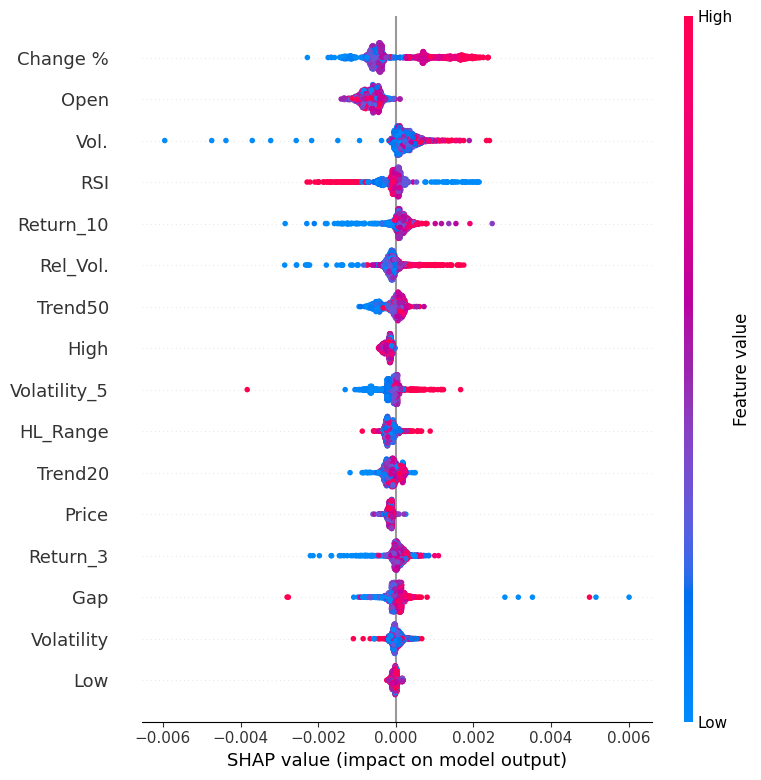

In [12]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)
plt.savefig('../plots/shap_summary.png', bbox_inches='tight')